In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import datetime

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

random_state = np.random.RandomState(0)

# import dataset

In [2]:
# Import X_small
X_small = pd.read_excel('X_small.xlsx')
X_small = X_small.drop(columns=['Unnamed: 0','flow'])
print(X_small.shape)
X_small.head()

(195500, 9)


,Dates,PERMNO,ret,ret_lag_1,ret_lag_2,ret_lag_3,flow_lag_1,flow_lag_2,flow_lag_3
0,19930406,55976,-0.067227,-0.024590,-0.020080,-0.019685,-5.642141,-6.975709,-4.696503
1,19930407,55976,0.000000,-0.067227,-0.024590,-0.020080,-6.975709,-5.642141,-6.975709
2,19930408,55976,0.040541,0.000000,-0.067227,-0.024590,-6.975709,-6.975709,-5.642141
3,19930412,55976,0.038961,0.040541,0.000000,-0.067227,-6.975709,-6.975709,-6.975709
4,19930413,55976,-0.033333,0.038961,0.040541,0.000000,-3.351631,-6.975709,-6.975709


In [15]:
ticker = list(set(X_small.PERMNO.to_list()))

In [3]:
# Import P_small
P_small = pd.read_csv('P_small.csv')
P_small = P_small.drop(columns=['Unnamed: 0','Portfolio_flows']).dropna()
print(P_small.shape)
P_small.head()

(1955, 8)


,Dates,Portfolio_returns,Portfolio_flows_lag_1,Portfolio_flows_lag_2,Portfolio_flows_lag_3,Portfolio_returns_lag_1,Portfolio_returns_lag_2,Portfolio_returns_lag_3
0,19930406,-0.003112,-0.140873,-2.371056,-1.399531,0.003637,-0.015585,-0.001138
1,19930407,-0.001031,0.453289,-0.140873,-2.371056,-0.003112,0.003637,-0.015585
2,19930408,-0.000309,-0.559098,0.453289,-0.140873,-0.001031,-0.003112,0.003637
3,19930412,0.009771,0.160661,-0.559098,0.453289,-0.000309,-0.001031,-0.003112
4,19930413,0.003260,1.440657,0.160661,-0.559098,0.009771,-0.000309,-0.001031


# Regression definition
## rolling window for all stocks

In [54]:
def regress_rolling(df, start_index, window_size, permno, model):
    '''
    Parameters
    ----------
    df: dataframe, X
    start_date: int. When you want to start predicting from.
    window_size: int
    permno: string, the companies permno that we want to predict for
    model: 'RF' for random forest, 'GBDT' for gradient boosting

    '''
    if model == 'Linear':
        regressor = LinearRegression()
    if model == 'RF':
        regressor = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=random_state, oob_score=True)
    if model == 'GBDT':
        regressor = GradientBoostingRegressor(n_estimators=100, max_depth=50, random_state=random_state, oob_score=True)
        
    temp_df = df[df.PERMNO==permno].reset_index(drop=True)
    temp_df = temp_df.replace([np.inf, -np.inf], 0) # remove any infinity values
    scaler = preprocessing.StandardScaler() 
    looper = temp_df.Dates.iloc[start_index:].values # a list of dates to loop through

    dates = []
    train_MSE = []
    R2 = []
    Predicted_y = []
    True_y = []
    imp = []
    mean_y = []
    models = []
    
    # rolling regression
    for i, date in enumerate(tqdm(looper)):
        end = temp_df[temp_df.Dates==date].index[0]
        start = end - window_size
        
        X = temp_df.iloc[start:end,3:]
        y = temp_df.iloc[start:end, 2]
        X_scaled = scaler.fit_transform(X)
        
        X_train = X_scaled[:-1]
        y_train = y[:-1]
        X_test = X_scaled[-1:]
        y_test = y[-1:]
        
        regressor.fit(X_train, y_train.values.ravel()) 
        models.append(regressor)
        y_pred = regressor.predict(X_test)

        dates.append(date)
        train_MSE.append(mean_squared_error(y_train, regressor.predict(X_train)))
        R2.append(r2_score(y_train, regressor.predict(X_train)))
        mean_y.append(y_train.mean())
        Predicted_y.append(y_pred[0])
        True_y.append(y_test.values[0]) #这里可能有问题
        #imp.append(regressor.feature_importances_)
        
    result = pd.DataFrame(list(zip(dates,train_MSE,R2,mean_y,Predicted_y,True_y)), columns=['Date','MSE_train','R2_train','Historical_Mean','Predicted_Return','True_Return'])
    return models, result

## rolling window for portfolio

In [4]:
def regress_rolling_p(df, start_index, window_size, model):
    '''
    Parameters
    ----------
    df: dataframe
    start_date: int. When you want to start predicting from.
    window_size: int
    permno: string, the companies permno that we want to predict for
    model: 'RF' for random forest, 'GBDT' for gradient boosting

    '''
    if model == 'Linear':
        regressor = LinearRegression()
    if model == 'RF':
        regressor = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=random_state, oob_score=True)
    if model == 'GBDT':
        regressor = GradientBoostingRegressor(n_estimators=100, max_depth=50, random_state=random_state, oob_score=True)
        
    temp_df = df.reset_index(drop=True)
    temp_df = temp_df.replace([np.inf, -np.inf], 0) # remove any infinity values
    #print(temp_df.head())
    scaler = preprocessing.StandardScaler() 
    looper = temp_df.Dates.iloc[start_index:].values # a list of dates to loop through

    models = []
    dates = []
    train_MSE = []
    R2 = []
    mean_y = []
    Predicted_y = []
    True_y = []
    imp = []
    
    # rolling regression
    for i, date in enumerate(tqdm(looper)):
        end = temp_df[temp_df.Dates==date].index[0]
        start = end - window_size
        
        X = temp_df.iloc[start:end,2:]
        y = temp_df.iloc[start:end,1]
        X_scaled = scaler.fit_transform(X)
        
        X_train = X_scaled[:-1]
        y_train = y[:-1]
        X_test = X_scaled[-1:]
        y_test = y[-1:]
        
        regressor.fit(X_train, y_train.values.ravel()) 
        models.append(regressor)
        y_pred = regressor.predict(X_test)
        dates.append(date)
        train_MSE.append(mean_squared_error(y_train, regressor.predict(X_train)))
        R2.append(r2_score(y_train, regressor.predict(X_train)))
        mean_y.append(y_train.mean()) #这里可能有问题
        Predicted_y.append(y_pred[0])
        True_y.append(y_test.values[0])
        #imp.append(regressor.feature_importances_)
        
    result = pd.DataFrame(list(zip(dates,train_MSE,R2,mean_y,Predicted_y,True_y)), columns=['Date','MSE_train','R2_train','Historical_Mean','Predicted_Return','True_Return'])
    return models, result

# Implementation
## all stocks

In [55]:
## use first two stocks as a trial
start = time.process_time()
print("We now do regressions on " + str(len(ticker)) + " stocks. Stand by.")

# Looping through all of the PERMNOs and performing the regressions
ws = 252
start_index = ws + 1

results_100_dict = {}

for perm in ticker:
    models_100, result_100 = regress_rolling(X_small,start_index, ws, perm, 'Linear')
    results_100_dict[perm] = result_100
    
# Notify user
end = time.process_time()
print("Regression done!")
print('Running time: %s mins'%round((end-start)/60,2))

  1%|▊                                                                              | 18/1702 [00:00<00:09, 178.35it/s]

We now do regressions on 100 stocks. Stand by.


100%|█████████████████████████████████████████████████████████████████████████████| 1702/1702 [00:11<00:00, 153.58it/s]

Regression done!
Running time: 75.87 mins


In [57]:
results_100 = pd.DataFrame()
for i in tqdm(ticker): 
    res = results_100_dict[i]
    col_name = 'Cum_SSE_diff_'+str(i)
    diff_sse = (res.Historical_Mean - res.True_Return)**2 - (res.Predicted_Return - res.True_Return)**2
    results_100[col_name] = np.cumsum(diff_sse) 
    
results_100['Mean_Cum_SSE_diff'] = results_100.mean(axis=1)
results_100.head()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 907.02it/s]


,Cum_SSE_diff_23552,Cum_SSE_diff_40970,Cum_SSE_diff_64020,Cum_SSE_diff_29209,Cum_SSE_diff_27684,Cum_SSE_diff_23077,Cum_SSE_diff_42024,Cum_SSE_diff_32299,Cum_SSE_diff_11819,Cum_SSE_diff_24109,...,Cum_SSE_diff_64995,Cum_SSE_diff_52708,Cum_SSE_diff_55781,Cum_SSE_diff_63976,Cum_SSE_diff_75241,Cum_SSE_diff_67563,Cum_SSE_diff_22509,Cum_SSE_diff_59379,Cum_SSE_diff_75259,Mean_Cum_SSE_diff
0,0.000012,-0.000192,0.000048,-0.000757,-0.000049,0.000012,0.000024,0.012291,-0.000120,-0.000036,...,0.000099,-0.000255,0.000057,-0.000043,-0.000203,-0.000081,0.000009,-0.000034,-0.000106,0.000096
1,-0.000594,0.000694,0.000014,-0.000840,0.000130,0.000008,-0.000210,0.038055,-0.000540,-0.000050,...,0.000099,-0.000196,0.000078,-0.000043,-0.000239,-0.000181,0.000010,-0.000029,-0.000292,0.000323
2,0.000574,0.000391,0.000028,-0.001109,0.000123,0.000014,-0.000211,0.048712,-0.001428,-0.000035,...,0.000075,-0.000187,0.000072,-0.000079,-0.000589,-0.000231,0.000012,-0.000002,0.000888,0.000412
3,-0.000096,0.000382,0.000027,-0.001046,0.000157,0.000027,-0.000158,0.048466,-0.004771,-0.000005,...,0.000093,-0.000391,0.000172,-0.000101,-0.000589,-0.000572,0.000012,-0.000024,0.000878,0.000344
4,0.000072,-0.001122,0.000049,-0.001034,0.000158,0.000026,-0.000131,0.047938,-0.005386,0.000109,...,-0.000025,-0.000452,0.000134,-0.000099,-0.000666,-0.000729,0.000020,-0.000166,0.000866,0.000296


In [61]:
results_100_dict[32299].head()

,Date,MSE_train,R2_train,Historical_Mean,Predicted_Return,True_Return
0,19940406,0.006767,0.284013,0.003561,-0.081807,-0.111111
1,19940407,0.006756,0.286880,0.003450,0.062856,0.250000
2,19940408,0.006861,0.293681,0.004446,-0.084141,-0.100000
3,19940411,0.006656,0.308110,0.004772,-0.016422,0.000000
4,19940412,0.006411,0.329842,0.005215,0.023553,0.000000


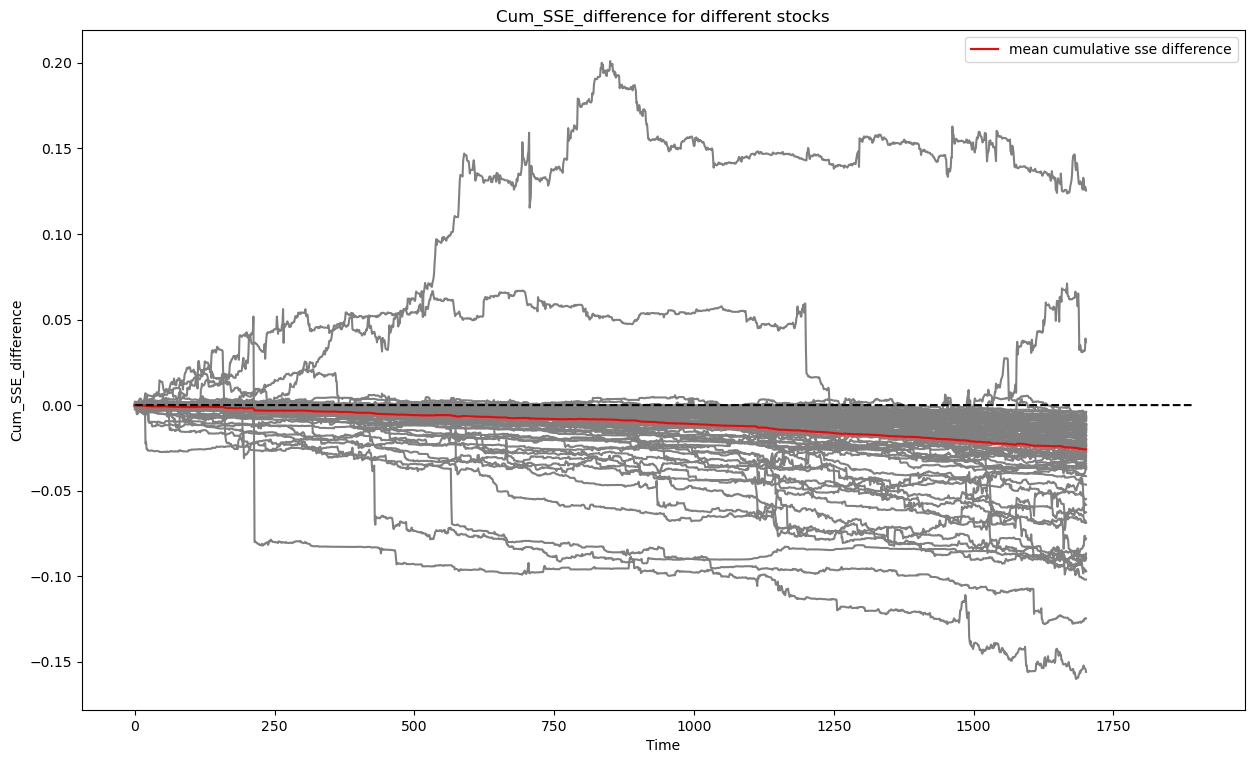

In [60]:
fig = plt.figure(figsize=(15,9), dpi=100)
ax = fig.add_subplot(111)

results_99 = results_100.drop(columns=['Cum_SSE_diff_32299'])
results_99['Mean_Cum_SSE_diff'] = results_99.mean(axis=1)
for i in range(len(ticker)):
    ax.plot(results_99.index, results_99.iloc[:,i], color='grey')
    
ax.plot(results_99.index, results_99['Mean_Cum_SSE_diff'], color='r', label='mean cumulative sse difference')

# 辅助线
sup_line = [0 for i in range(result_ws.shape[0])]
ax.plot(result_ws.index, sup_line, color='black', linestyle='--')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Cum_SSE_difference')
plt.title('Cum_SSE_difference for different stocks')

plt.savefig('linear_99_stocks.jpg')
plt.show()

## portfolio

In [5]:
start = time.process_time()
print("We now do regressions on equally-weighted portfolio.")

ws = 252
start_index = ws + 1
models_p, result_p = regress_rolling_p(P_small,start_index, ws, 'Linear')
 
# Notify user
end = time.process_time()
print("Regression done!")
print('Running time: %s mins'%round((end-start)/60,2))

  1%|▌                                                                              | 11/1702 [00:00<00:16, 105.00it/s]

We now do regressions on equally-weighted portfolio.


100%|█████████████████████████████████████████████████████████████████████████████| 1702/1702 [00:15<00:00, 111.34it/s]

Regression done!
Running time: 1.01 mins


In [6]:
result_p['diff_sse'] = (result_p.Historical_Mean - result_p.True_Return)**2 - (result_p.Predicted_Return - result_p.True_Return)**2
result_p['Cum_SSE_diff'] = np.cumsum(result_p.diff_sse) 
result_p.head()

,Date,MSE_train,R2_train,Historical_Mean,Predicted_Return,True_Return,diff_sse,Cum_SSE_diff
0,19940406,0.000025,0.074276,0.000467,-0.004272,0.023475,-0.000241,-0.000241
1,19940407,0.000027,0.045395,0.000565,0.006013,0.003069,-0.000002,-0.000243
2,19940408,0.000027,0.045139,0.000578,0.000939,0.005718,0.000004,-0.000239
3,19940411,0.000027,0.047302,0.000562,0.000829,-0.008421,-0.000005,-0.000244
4,19940412,0.000027,0.046306,0.000516,-0.001128,0.001664,-0.000006,-0.000251


## window size selection

In [40]:
start = time.process_time()
print("We now do regressions on equally-weighted portfolio.")

# Looping through all of the windows and performing the regressions
results_ws_dict = {}
models_ws_dict = {}

for ws in tqdm(np.arange(63,273,21)): 
    start_index = ws + 1
    models_p_ws, result_p_ws = regress_rolling_p(P_small,start_index, ws, 'Linear')
    results_ws_dict[ws] = result_p_ws
    models_ws_dict[ws] = models_p_ws
    
# Notify user
end = time.process_time()
print("Regression done!")
print('Running time: %s mins'%round((end-start)/60,2))

  1%|▍                                                                               | 10/1891 [00:00<00:18, 99.74it/s]

We now do regressions on equally-weighted portfolio.



 56%|███████████████████████████████████████████▉                                  | 1064/1891 [00:14<00:11, 74.86it/s]


 14%|██████████▉                                                                    | 259/1870 [00:03<00:24, 66.55it/s]


 67%|████████████████████████████████████████████████████                          | 1247/1870 [00:18<00:08, 70.47it/s]


 21%|████████████████▎                                                              | 383/1849 [00:05<00:20, 70.19it/s]


 78%|████████████████████████████████████████████████████████████▉                 | 1444/1849 [00:20<00:05, 68.37it/s]


 30%|███████████████████████▋                                                       | 548/1828 [00:08<00:19, 67.19it/s]


 84%|█████████████████████████████████████████████████████████████████▊            | 1541/1828 [00:22<00:04, 67.08it/s]


 38%|██████████████████████████████▎                                                | 694/1807 [00:10<00:16, 67.20it/s]


 93%|████████████████████████████████████████████████████████████████████████▍     | 1678/1807 [00:24<00:02, 63.66it/s]


 47%|█████████████████████████████████████▌                                         | 848/1786 [00:12<00:13, 68.26it/s]


  2%|█▍                                                                              | 31/1765 [00:00<00:23, 73.82it/s]


 57%|████████████████████████████████████████████▊                                 | 1014/1765 [00:14<00:11, 68.09it/s]


 15%|████████████▏                                                                  | 269/1744 [00:03<00:21, 68.66it/s]


 72%|████████████████████████████████████████████████████████▍                     | 1262/1744 [00:18<00:06, 69.30it/s]


 30%|████████████████████████                                                       | 524/1723 [00:07<00:18, 66.35it/s]


 88%|████████████████████████████████████████████████████████████████████▉         | 1524/1723 [00:22<00:02, 69.58it/s]


 45%|███████████████████████████████████▌                                           | 767/1702 [00:11<00:14, 66.40it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:19<00:00, 25.95s/it]

Regression done!
Running time: 15.07 mins


In [42]:
result_ws = pd.DataFrame()
for ws in tqdm(np.arange(63,273,21)): 
    res = results_ws_dict[ws]
    col_name = 'Cum_SSE_diff_'+str(ws)
    diff_sse = (res.Historical_Mean - res.True_Return)**2 - (res.Predicted_Return - res.True_Return)**2
    result_ws[col_name] = np.cumsum(diff_sse) 
    
result_ws.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 214.97it/s]


,Cum_SSE_diff_63,Cum_SSE_diff_84,Cum_SSE_diff_105,Cum_SSE_diff_126,Cum_SSE_diff_147,Cum_SSE_diff_168,Cum_SSE_diff_189,Cum_SSE_diff_210,Cum_SSE_diff_231,Cum_SSE_diff_252
0,0.000006,-0.000018,9.685362e-07,0.000005,0.000001,-0.000018,-0.000020,3.711518e-07,0.000002,-0.000241
1,-0.000003,-0.000030,2.008729e-05,0.000001,0.000119,-0.000025,0.000005,-5.561464e-07,0.000024,-0.000243
2,0.000004,-0.000027,5.530408e-05,-0.000002,0.000104,-0.000026,-0.000005,6.166021e-05,0.000013,-0.000239
3,0.000004,-0.000026,6.872532e-06,-0.000019,0.000104,-0.000024,-0.000010,-1.717116e-05,0.000018,-0.000244
4,-0.000019,-0.000026,5.431980e-06,0.000014,0.000103,-0.000027,-0.000006,-1.589093e-05,0.000016,-0.000251


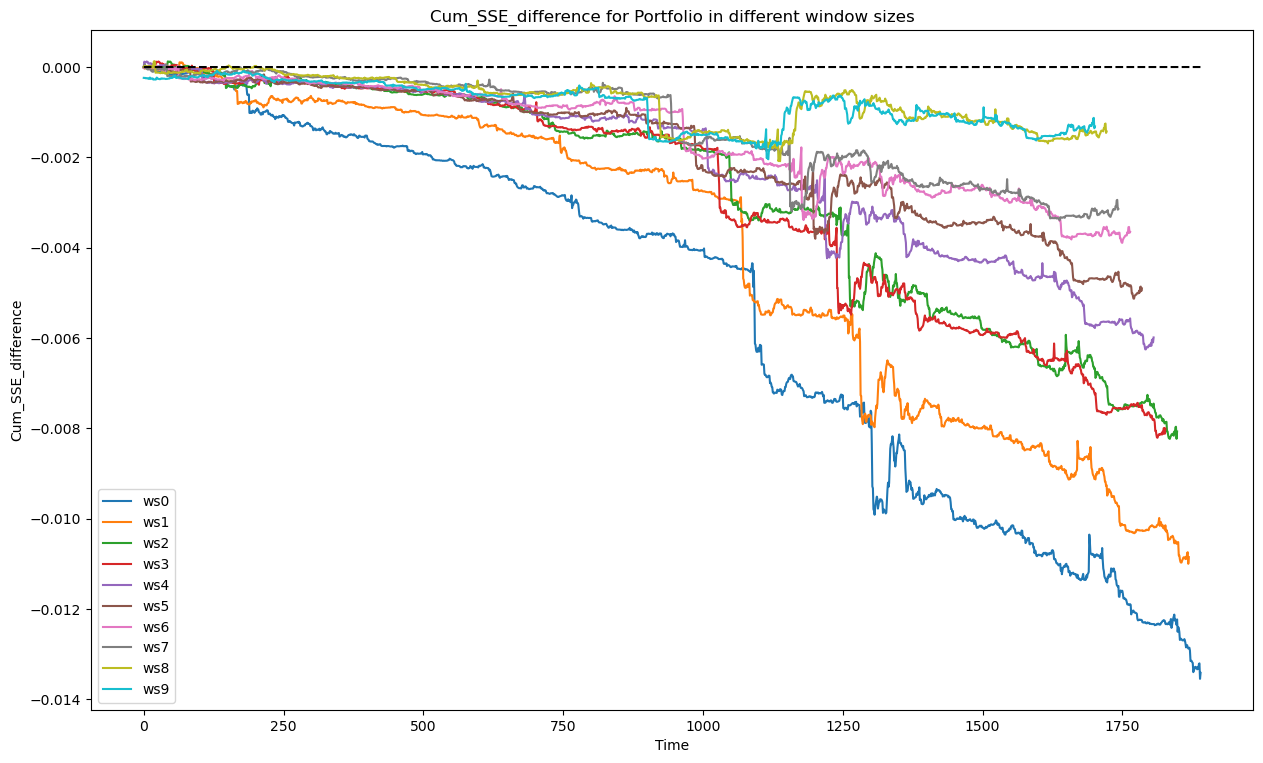

In [45]:
fig = plt.figure(figsize=(15,9), dpi=100)
ax = fig.add_subplot(111)

for i in range(result_ws.shape[1]):
    ax.plot(result_ws.index, result_ws.iloc[:,i], label='ws'+str(i))

plt.legend()
plt.xlabel('Time')
plt.ylabel('Cum_SSE_difference')
plt.title('Cum_SSE_difference for Portfolio in different window sizes')

# 辅助线
sup_line = [0 for i in range(result_ws.shape[0])]
ax.plot(result_ws.index, sup_line, color='black', linestyle='--')

plt.savefig('linear_ws_selection.jpg')
plt.show()